## Predicting Kickstarter success

Steps:
* First step is to clean the data
* Then we'll plot some graphs to get an idea of which features affect project success
* Then we'll engineer some new features
* Finally we'll build the model, evaluate it, and interpret the results
 

Assumptions:

1. Projects can only be funded in the currency of their country of origin (i.e. USD for US, GBP for GB, etc) (ref. https://help.kickstarter.com/hc/en-us/articles/115005132733-What-currency-will-my-pledge-be-collected-in-)  
2. Data integrity is not correlated with the target (successful backing). This should be a safe assumption here, so we can safely drop bad data if it is not too frequent.
3. As per the problem statement, the goal is to create a model which can predict whether a kickstarter campaign will be successful _a priori_. Therefore, the state, the amount pledged and the number of backers will not be used in the model

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Data cleaning

Read in the data to a pandas dataframe:

In [2]:
PATH_TO_FILE = 'data\\ks-projects-201612.csv'
data = pd.read_csv(PATH_TO_FILE, encoding = "latin", low_memory=False)
data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,NaN
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,NaN
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,NaN,NaN,NaN,NaN
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,NaN,NaN,NaN,NaN


Firstly, the column labels also all have trailing spaces, so let's tidy that up.  
Also, the ID column won't be useful to us so we can drop it.

I won't be using the 'name' column in my model. Any effect is likely to be due to the semantic meaning of the name, rather than the characters contained. While it would be possible to map the name to a feature vector (e.g using a convolutional neural network), that would be beyond the scope of this first model  
  
Some of the data is entered badly due to missing values, with the remaining values shifted into the wrong columns. We can see this if we look at the currencies:

In [3]:
data.columns = [col_name[:-1] for col_name in data.columns]  #remove trailing space
data.drop(['ID', 'name'], axis=1, inplace=True)              #Drop un-used columns
data['currency'].value_counts()

USD                   260298
GBP                    27968
CAD                    12197
EUR                    11555
AUD                     6347
SEK                     1300
NZD                     1164
DKK                      841
NOK                      540
CHF                      478
MXN                      214
Publishing               123
SGD                      119
HKD                       97
Film & Video              83
Music                     73
Art                       64
Technology                44
Design                    44
Food                      44
Games                     36
Fashion                   32
Photography               25
Journalism                14
Comics                    13
Theater                   13
Crafts                    10
Dance                      5
Nonfiction                 1
Rock                       1
 Religion                  1
 Be active!                1
 tango and culture         1
Painting                   1
Software      

We can test which lines are 'bad' by seeing if they have a recognized value for the currency:

In [4]:
currencies = ['USD','GBP','CAD', 'AUD','NOK', 'EUR','SEK', 'NZD', 'DKK', 'CHF', 'MXN', 'SGD', 'HKD']    #Recognised currencies
bad_data = data[~data['currency'].isin(currencies)]['currency'].count()
print("The number of bad lines is {} out of {} ({:.2f}%)".format(bad_data, len(data), bad_data*100/len(data)))

The number of bad lines is 632 out of 323750 (0.20%)


That's not very many. We could work out which columns the missing values are from and shift the rest, but since there are so few, its probably safe to just drop those lines (see assumption 2)   
Also, according to assumption 1, 'usd pledged' is redundant, as usd_pledged=pledged if country=US and 0 otherwise, so we'll drop the usd_pledged column too.  

In [5]:
data = data[data['currency'].isin(currencies)]
data.drop(data.columns[[10, 11, 12, 13,14]], axis=1, inplace=True)

In [6]:
data['currency'].unique()

array(['GBP', 'USD', 'CAD', 'NOK', 'AUD', 'EUR', 'MXN', 'SEK', 'NZD',
       'CHF', 'DKK', 'HKD', 'SGD'], dtype=object)

That looks good. However, in order for the 'goal' amount to be a good predictor, we need to convert all the projects to the same currency.
This is because a 1,000,000 USD project is not comparable to a 1,000,000 MXN (approx. 50,000 USD) project.  

One could argue that this isn't necessary, since the currency information is contained in the 'currency' or 'country' column, but it is nonetheless beneficial to factor out the currency so that the 'country' column  carries purely demographic information (rather than demographic + currency).

We'll use exchange rates valid on the 09/01/2019, convert all to USD, and drop the 'currency' column. No demographic information is lost in doing so, since the country column is preserved.

Before we do that, we need to put the data in the correct format:

In [7]:
strings='category main_category currency country state'.split(' ')
ints='backers'.split(' ')
floats='goal pledged'.split(' ')
dates='launched deadline'.split(' ')

for col in data.columns:
    if col in strings:
        data[col] = data[col].apply(str)
    elif col in ints:
        data[col] = data[col].apply(int)
    elif col in floats:
        data[col] = data[col].apply(float)
    elif col in dates:
        data[col] = data[col].apply(pd.to_datetime)

In [8]:
rates = {currency:0 for currency in data['currency'].unique()}  #Rates from Google on 09/01/2018.
rates['GBP']=1.28
rates['USD']=1
rates['CHF']=1.02
rates['CAD']=0.76 
rates['NOK']=0.12
rates['AUD']=0.72 
rates['EUR']=1.15 
rates['MXN']=0.052
rates['SEK']=0.11
rates['NZD']=0.68
rates['DKK']=0.15
rates['HKD']=0.13
rates['SGD']=0.74

In [9]:
data['goal'] = data['goal']*data['currency'].map(rates)     #Replace goal columns with goal converted to USD
data['pledged'] = data['pledged']*data['currency'].map(rates) #same for amount pledged (target)
data.drop('currency', axis=1, inplace=True)
data.head()

,category,main_category,deadline,goal,launched,pledged,state,backers,country
0,Poetry,Publishing,2015-10-09 11:36:00,1280.0,2015-08-11 12:12:28,0.0,failed,0,GB
1,Narrative Film,Film & Video,2013-02-26 00:20:50,45000.0,2013-01-12 00:20:50,220.0,failed,3,US
2,Music,Music,2012-04-16 04:24:11,5000.0,2012-03-17 03:24:11,1.0,failed,1,US
3,Film & Video,Film & Video,2015-08-29 01:00:00,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US
4,Restaurants,Food,2016-04-01 13:38:27,50000.0,2016-02-26 13:38:27,52375.0,successful,224,US


Now let's look at our target: 'state' 

In [10]:
data['state'].value_counts()

failed        168221
successful    113081
canceled       32354
live            4428
undefined       3555
suspended       1479
Name: state, dtype: int64

Any funding rounds which are live or suspended are not useful to us (for the problem as stated) since we don't know if they will succeed or fail (for our purposes, they are unlabeled), so we drop them.  
One approach for canceled campaigns would be to consider them to have failed. However, reasons for cancelling a campaign could well be more complex (perhaps they were so successful that they secured funding privately). We will simply exclude them from our data.  
Since we don't know whether 'undefined' campaigns are live or not, we will drop them too.

In [11]:
data = data[data['state'].isin(['successful', 'failed'])]    #Keep only successful and failed campaigns
data['state'].value_counts()

failed        168221
successful    113081
Name: state, dtype: int64

Finally, let's check that none of the 'successful' campaigns are falsely labelled:

In [12]:
data[(data['state']=='successful') & (data['pledged']<data['goal'])]

,category,main_category,deadline,goal,launched,pledged,state,backers,country
62072,Art,Art,2012-08-27 15:58:00,3600.0,2012-07-26 03:31:28,3599.690,successful,64,US
129658,Shorts,Film & Video,2015-12-27 19:06:18,36000.0,2015-11-12 19:06:18,30716.000,successful,275,US
198903,Documentary,Film & Video,2010-07-18 05:59:00,8000.0,2010-06-02 22:15:38,7999.650,successful,73,US
235954,Art,Art,2010-07-08 23:39:00,2000.0,2010-05-27 00:26:33,1999.660,successful,30,US
287254,Product Design,Design,2016-03-19 18:14:02,28750.0,2016-02-08 19:14:02,28626.375,successful,90,DE


Some of the campaigns were considered successful even though they fell slightly short of their target, though this occurs only 5 times. (The same is true for mis-labeled failed campaigns : 6 instances)

The data is now cleaned, and we can move on to exploratory data analysis

## Exploratory data analysis

According to assumption 3, the features to be exploited are:  

* category
* main category
* deadline
* launched
* goal
* country  

First let's see how many successful and failed funding campaigns there were and the distribution of their goals

<BarContainer object of 2 artists>

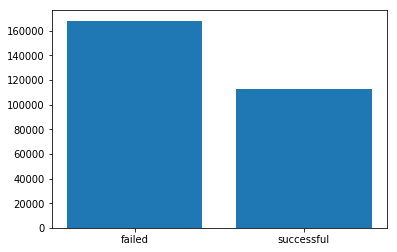

In [13]:
plt.bar(x=['failed', 'successful'], height=[len(data[data['state']=='failed']), len(data[data['state']=='successful'])])

We have highly imbalanced classes.

An overview of successful and failed projects:

In [14]:
print('successful projects\n', data[data['state']=='successful'].describe())
print('\nfailed projects\n', data[data['state']=='failed'].describe())

successful projects
                goal       pledged        backers
count  1.130810e+05  1.130810e+05  113081.000000
mean   9.363968e+03  2.087622e+04     253.624322
std    2.880415e+04  1.452684e+05    1559.480049
min    1.000000e-02  7.600000e-01       0.000000
25%    1.300000e+03  1.953000e+03      32.000000
50%    3.600000e+03  5.010000e+03      69.000000
75%    1.000000e+04  1.244390e+04     160.000000
max    2.000000e+06  2.033899e+07  219382.000000

failed projects
                goal        pledged        backers
count  1.682210e+05  168221.000000  168221.000000
mean   6.108570e+04    1321.396209      16.771230
std    1.350172e+06    7008.613165      74.749984
min    1.500000e-01       0.000000       0.000000
25%    2.500000e+03       2.000000       1.000000
50%    7.000000e+03     100.000000       3.000000
75%    2.000000e+04     660.000000      12.000000
max    1.280000e+08  757352.940000    6550.000000


We can see immediately that there is vast variation in even the order of magnitude  of funding goals. This suggests that log(goal) might be a more useful predictor.  
We can plot a histogram of log(goal) for both successful and failed projects:

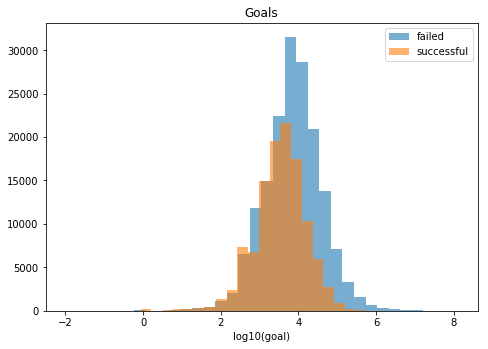

In [15]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
bins=30
ax.hist(np.log10(data[data['state']=='failed']['goal']), bins=30, label='failed', alpha=0.6)
ax.hist(np.log10(data[data['state']=='successful']['goal']), bins=bins, label='successful', alpha=0.6)
ax.set_title('Goals')
ax.set_xlabel('log10(goal)')
ax.legend()

The distributions are fairly normally distributed in for log(goal). There is a slight bi-modal tendancy in both distributions (with a secondary peak at 200), although this is likely explained by the use of various currencies (more on this later).  
As expected, the 'failed' graph is shifted to a higher mean goal than 'successful'. Projects which are too ambitious with their goal are more likely to fail.\
  
  
We can also look at the success rate by category, for each categorical variable.
We add the option to plot only the N most successful and least succesful categories (useful for 'category' where the number of categories is very high)

In [16]:
def plot_cat(cat, top=False):        #Function to plot the success rate by category for a given categorical variable
    
    cat_summary = pd.DataFrame(data.groupby(by=cat)['state'].value_counts()).unstack()
    cat_summary.columns = ['failed', 'successful']
    cat_summary['success_rate'] = cat_summary['successful'] / (cat_summary['successful']+cat_summary['failed'])
    cat_summary.sort_values('success_rate', ascending=False, inplace=True)
    cat_summary.reset_index(inplace=True)
    cat_summary.head()

    fig = plt.figure(figsize=(10,3))
    ax = fig.add_subplot(111)

    if top:
        ax.bar(x=cat_summary[cat].head(top), height=cat_summary['success_rate'].head(top))
        ax.bar(x=cat_summary[cat].tail(top), height=cat_summary['success_rate'].tail(top))
    else:
        ax.bar(x=cat_summary[cat], height=cat_summary['success_rate'])

    plt.xticks(rotation='vertical')
    plt.title(f'Success rate by {cat}')

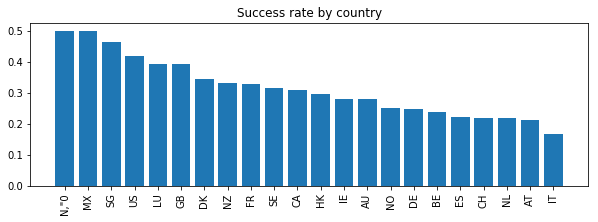

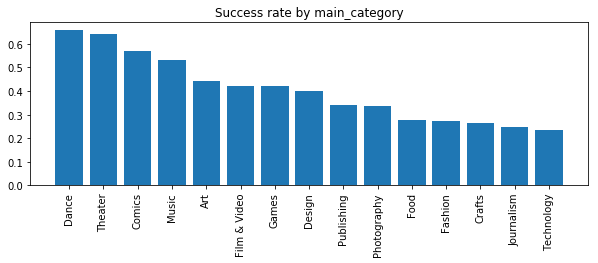

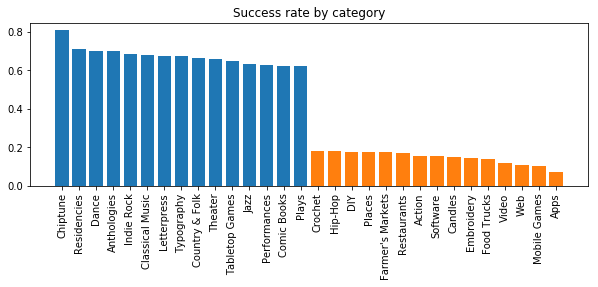

In [17]:
plot_cat('country')
plot_cat('main_category')
plot_cat('category', top=15)  #Lots of categories so plot only the best and worst 15 categories

It looks like country, main_category, and category are all good predictors of success.

## Feature engineering 

We can introduce a new column for the amount funded (pledged/goal). This will be useful for comparing with the goal, but also when we create the predictive model. It's probably better to use the model to predict funding %, and then deduce whether the goal was met (>=100%), in order not to lose information from the training data. i.e. 99% funded is very different to 1% funded, but both give simply 'failed'

Let's also turn the date columns into something more useful. Instead of 'launched' and 'deadline', we'll have the month of the launch and the deadline, and the duration in days.  
This will preserve both the time of year and the duration, both potentially predictive attributes

We also add in 'dollars per day', as the higher the goal, the more time required to fund, even if the project is strongly supported.

In [18]:
data['duration'] = (data['deadline'] - data['launched']).apply(lambda duration: duration.days)
data['log_goal'] = data['goal'].apply(np.log10)
data['dollars_per_day'] = data['goal'] /  data['duration']
data['log_dollars_per_day'] =  data['dollars_per_day'].apply(np.log10)
data['funded'] = data['pledged'] / data['goal']
data['launched_quarter'] = data['launched'].apply(lambda date: (date.quarter))
data['deadline_quarter'] = data['deadline'].apply(lambda date: (date.quarter))

data.drop(['deadline', 'launched'], axis=1, inplace=True)

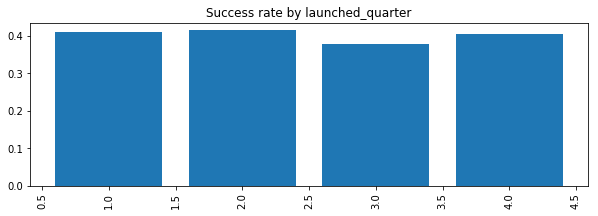

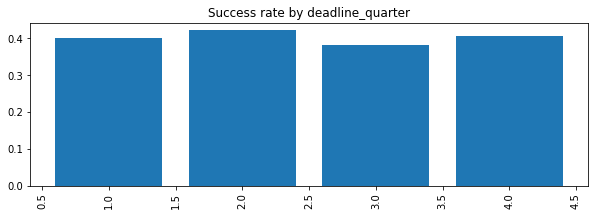

In [19]:
plot_cat('launched_quarter')
plot_cat('deadline_quarter')

Success looks weakly dependent on quarter. Interestingly, we see the same tendency for both launched quarter and deadline quarter, with quarters 2 and 4 being the most successful.  
This points to some very strong grouping of project durations:

In [20]:
print('Successful projects: \n', (data[data['state'] == 'successful']['duration']).value_counts().head())       #Get most common durations of successful and failed projects
print('\nFailed projects: \n', (data[data['state'] == 'failed']['duration']).value_counts().head())

print('\n% projects with a duration of between 29 and 61 = {:.1f}%'.format(100*data[data['duration'].between(29,61)]['duration'].count()/len(data)))

Successful projects: 
 30    42725
29     5969
60     4722
31     4449
45     4086
Name: duration, dtype: int64

Failed projects: 
 30    75845
60    16429
29     8832
45     8234
40     4167
Name: duration, dtype: int64

% projects with a duration of between 29 and 61 = 81.0%


Indeed, both successful and failed projects tend to last between one and two months.

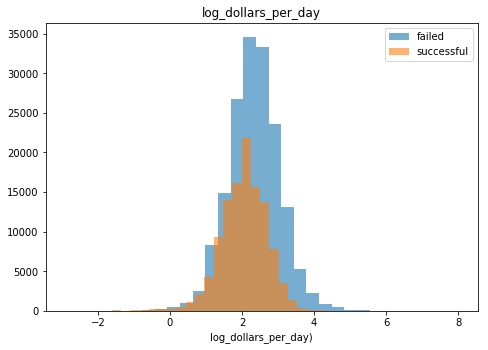

In [21]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
bins=30
ax.hist(data[data['state']=='failed']['log_dollars_per_day'], bins=bins, label='failed', alpha=0.6)
ax.hist(data[data['state']=='successful']['log_dollars_per_day'], bins=bins, label='successful', alpha=0.6)
ax.set_title('log_dollars_per_day')
ax.set_xlabel('log_dollars_per_day)')
ax.legend()

Log(dollars per day) is normally distibuted. As suspected, the secondary peak was indeed an artefact of using different currencies.

We'll drop 'goal' and 'dollars per day' as features in favour of the logs of their values

In [22]:
model_data = data.copy(deep=True)  #We're about to encode our categorical variables so make a deep copy here.

## Create model

The model proposed is a random forest regressor. Although we are attempting to classify into 'successful' and 'failed', the category into which each example fits is perfectly described by the 'funded' value :  if it is 100% funded or greater, it is successful, otherwise it has failed. Using a regressor preserves information about how successful a campaign is predicted to be, even if it was not 'successful' as per the 100% requirement.

Python's SKLearn library requires that categorical variables be encoded to numerical before fitting. This isn't a requirement of decision trees in a general sense, rather a limitation of the library. One consequence of this is that the categories of each variable are assigned an order which does not exist in reality (no category is 'greater' than another - they are orthogonal). To overcome this, it is possible to once again make the categories orthogonal, by one-hot encoding the variable. However, this makes the data very sparse, causing convergence concerns. Here, we will simply encode the labels and accept the unrealistic ordinality.  

Since we're using a random forest, there's no need to scale and normalize the data

In [23]:
from sklearn import preprocessing

model_data.drop(['pledged', 'state', 'backers', 'goal', 'dollars_per_day'], axis=1, inplace=True)

categoricals = model_data[['main_category', 'category', 'country']] 
model_data.drop(categoricals, axis=1, inplace=True)

#Label encode
le = preprocessing.LabelEncoder()
categoricals = categoricals.apply(le.fit_transform)

model_data=pd.concat([model_data, pd.DataFrame(categoricals)], axis=1).dropna()
model_data.head()  # A final look at the data to be fed into the algorithm

,duration,log_goal,log_dollars_per_day,funded,launched_quarter,deadline_quarter,main_category,category,country
0,58,3.107210,1.343782,0.000000,3,4,12,107,9
1,45,4.653213,3.000000,0.004889,1,1,6,92,21
2,30,3.698970,2.221849,0.000200,1,2,10,89,21
4,35,4.698970,3.154902,1.047500,1,2,7,122,21
5,20,3.000000,1.698970,1.205000,4,4,7,58,21


In [24]:
from sklearn.model_selection import train_test_split         #split the data into features and target, train
X = model_data.drop('funded', axis=1)
y = model_data['funded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)#Random seed for reproduciblity

In [25]:
from sklearn.ensemble import RandomForestRegressor     #Create and run model

model = RandomForestRegressor(n_estimators=100, random_state=101)  #Random seed for reproduciblity

model.fit(X_train, y_train)
result = model.predict(X_test)
features =  model.feature_importances_

prediction = [0 if funded<1 else 1 for funded in result]      #Convert predicted and truth lists of funded % into lists of success or fail
truth = [0 if funded<1 else 1 for funded in y_test]

C:\Users\Simon\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Evaluate and interpret model

In [26]:
from sklearn.metrics import confusion_matrix, classification_report  
cf = confusion_matrix(truth, prediction)
cr = classification_report(truth, prediction, target_names=['failed', 'successful'])

print(cr)

print('(Positive = Success predicted)')
print(f'True Positives = {cf[1][1]}')
print(f'False Positives = {cf[0][1]}')
print(f'True Negatives = {cf[0][0]}')
print(f'False Negatives = {cf[1][0]}') 
accuracy=(cf[0][0]+ cf[1][1])/cf.sum()
print('\nOverall Accuracy = {:.1f}%'.format(100*accuracy))

             precision    recall  f1-score   support

     failed       0.65      0.80      0.72     50280
 successful       0.55      0.35      0.43     34111

avg / total       0.61      0.62      0.60     84391

(Positive = Success predicted)
True Positives = 11889
False Positives = 9838
True Negatives = 40442
False Negatives = 22222

Overall Accuracy = 62.0%


We're able to obtain an overall accuracy of around 62%. However, the data is quite unbalanced, so we should consider the precision and recall for each class.  
* 80% of failed projects are correctly identified, whereas only 35% of successful projects are.   
* 65% of projects predicted to fail actually did, whereas 55% of projects predicted to succeed actually did.  

The algorithm has a tendency to over-predict failure.

When run many times over (this time without the randomn seed on the test/train split and random forest) the algorithm is stable.  

We can look at which of our features were deemed most predictive by the model:

Feature importance:


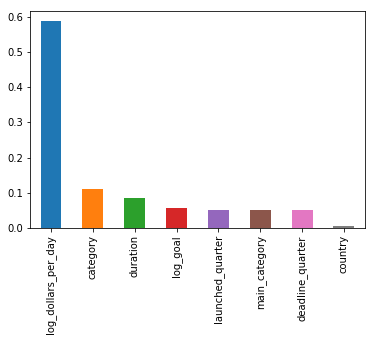

In [27]:
ftr_imp_rf=zip(X_train.columns, features)  #get feature importance for each variable and plot in descending order
print("Feature importance:")
pd.Series({value[0]: value[1] for value in sorted(ftr_imp_rf, key=lambda x: x[1], reverse=True)}).plot(kind='bar')

Log dollars per day was by far the most powerful indicator. Interestingly, 'country' was insignificant once the currency information was factored out, despite the most succesful country having a success rate of twice that of the least successful. This is likely to be because the projects are overwhelmingly from just a few of the countries (US, GB, AU), each with a similar success rate. This class imbalance is likely to be present in many of the categorical variables, limiting their predictive power.

Possible improvements:
* Obtain more data (or more balanced data)
* Engineer more  (or better) features (We could try to engineer something from the names, e.g. name length, presence of '!' or '?', presence of certain words, etc. We could even use a neural network to create a semantic feature map of the names, although this is costly and would require a lot more data)
* Tune the algorithm. As long as the number of trees is sufficient, there's not much gain to adding more. We could also tune the algorithms hyperparameters via grid search, though the expected gain is probably fairly low
* Perform k-fold cross validation. 